In [1]:
#Load packages and functions

import numpy as np
import astropy.io.fits as fits
import glob
import matplotlib.pyplot as plt
import astropy
from astropy import modeling
from scipy.signal import argrelextrema
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit

#wavelength, flux
def wf(dat): #whichord,dat. Setup:   w,f=wf(#,dat)
    w=np.array([d[0] for d in dat])
    f=np.array([d[1] for d in dat])
    return w,f

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar=''): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    if len(params)==1:
        varrs=varrs[0]
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')

# Wavelength Calibration Functions

In [10]:
#Open laboratory Ne lines:
wN,fN=opendat('',r'C:\Users\ZY\Documents\github\233boy\StarsinRadiationEnvironment\NeLines.dat',['#wavelength','flux'])

#Open e-fits file:
def efits(file):
    hdu=fits.open(file)
    data=hdu[0].data
    head=hdu[0].header
    hdu.close()
    return data #flux

#Define pixel-center-finding function:
#Operates on e..._comp.fits files.
def centralpixels(f,pltt='n'): #give flux from e-type comp file, toggle plots; compare to lab Ne at end
    maxx=[i for i in argrelextrema(f,np.greater)[0] if f[i]>10000]
    print(maxx)
    for m in maxx:
        print(m,':',f[m])
        
    #check you got them all:
    if pltt=='y':
        plt.figure()
        plt.plot(f)
        plt.scatter(maxx,np.array(f)[np.array(maxx)],c='darkorange')
        plt.xlabel('pixel')
        plt.ylabel('flux count')
    
    #Fit each maxx line peak out to 5000 flux counts:
    pcs=[] #pixel centers
    for i in range(len(maxx)):
        #go out left until below 5000, out right until below 5000
        cp=maxx[i] #central pixel
        b,e=cp-10,cp+10

        p=[] #left edge of line
        i=cp
        #print(f[i])
        while f[i]>5000 and abs(cp-i)<10:
            p.append(i)
            i-=1
        l=np.min(p)

        p=[] #right edge of line
        i=cp
        #print(f[i])
        while f[i]>5000 and abs(cp-i)<10:
            p.append(i)
            i+=1
        r=np.max(p)

        del p
        #print(l,r)

        pe=np.array(range(l,r)) #pixels of the emission line
        fe=np.array([f[i] for i in pe]) #fluxes of the emission line
        
        if pltt=='y':
            plt.figure()
            plt.plot(range(b,e),f[b:e])
            plt.plot(pe,fe)
            plt.xticks([b,l,cp,r,e])
            plt.xlabel('pixel')
            plt.ylabel('flux count')
        
        #fit a Gaussian to the emission line to find its center!

        PE = ar(pe)
        FE = ar(fe)

        n = len(FE)  ## <---
        mean = sum(FE*PE)/n
        sigma = sqrt(sum(FE*(PE-mean)**2)/n)

        def gaus(x,a,mu,sigma):
            return a*exp(-(x-cp-mu)**2/(2*sigma**2))

        popt,pcov = curve_fit(gaus,PE,FE)#,p0=[0.18,mean,sigma])  ## <--- leave out the first estimation of the parameters

        xx = np.linspace( cp-10, cp+10, 100 )  ## <--- calculate against a continuous variable
        pc=cp+popt[1] #central wavelength
        
        if pltt=='y':
            plt.figure()
            plt.scatter(PE, FE, label = "Measured",c='deepskyblue')
            plt.plot(xx,gaus(xx,*popt),c='darkorange',label='Fit')  ## <--- plot against the contious variable
            plt.scatter(pc,gaus(pc,*popt),zorder=10,marker='+',s=100,c='red')
            plt.xticks([b,l,cp,r,e])
            plt.xlabel('pixel')
            plt.ylabel('flux count')
        
        print('Pixel center of emission line:',pc)
        pcs.append(pc)
    
    #Check results against lab Ne
    print('\nNeon lines needed:',len(wN))
    print('emission lines found:',len(pcs))
    if len(wN)-len(pcs)>0:
        print('!!! line(s) not found!')
    plt.figure()
    plt.plot(f)
    for p in pcs:
        plt.plot([p,p],[np.min(f),np.max(f)],c='darkorange',alpha=0.5)
    
    return pcs

# Make list of calibrated wavelengths:
def wcal(f,plttt='n'): #input e..._comp.fits comparison lamp file
    #find central pixel locations of lamp emission lines:
    pc=centralpixels(f,pltt=plttt)
    
    # Take list of pixel centers and laboratory neon line wavelengths and map pixels to wavelengths.
    wfitz,a,b,c,d=np.polyfit(pc,wN,3,full=True)
    print(a[0])

    x=range(len(f))
    wfit=np.poly1d(wfitz)
    w=wfit(x)
    if plttt=='y':
        plt.figure()
        plt.scatter(pc,wN)
        plt.plot(x,w)
        
    return w

#look at results and see if Ha is in right place:
def plotspec(w,fstar):
    plt.figure()
    plt.plot(w,fstar)
    plt.plot([6563,6563],[np.min(fstar),np.max(fstar)],c='red',lw=1)
    plt.title(starname+'_unnorm')
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Flux Counts')

['#wavelength', 'flux']


# Procedure

Pick an object.

Open e-files, one with just the star (e....fits), and one with the star and comparison lamp (e..._comp.fits).

Run wcal on comparison lamp's flux. Get wavelengths.

Assign wavelengths to star's flux. Write a new file, wavelength-calibrated unnormalized.

Text(0, 0.5, 'flux')

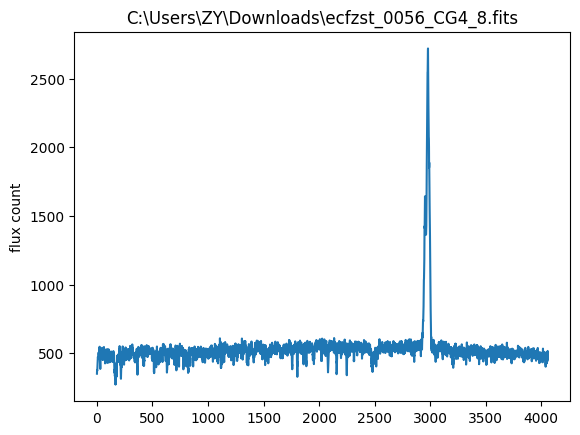

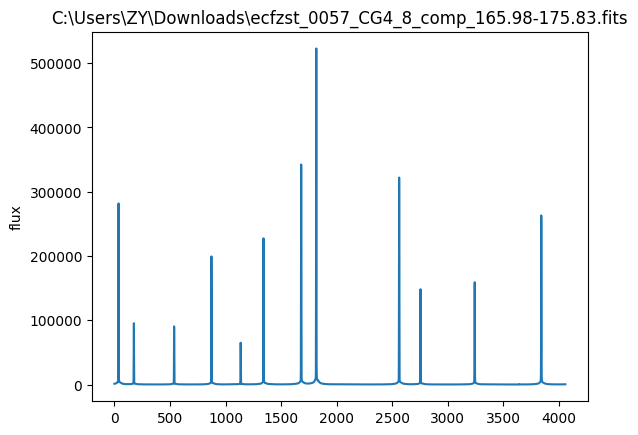

In [9]:
#Get fluxes from opening e-files.

#star
starfile=r'C:\Users\ZY\Downloads\ecfzst_0056_CG4_8.fits'
fstar=efits(starfile)
#check:
plt.figure()
plt.title(starfile)
plt.plot(fstar)
plt.ylabel('flux count')

#comparison lamp
lampfile=r'C:\Users\ZY\Downloads\ecfzst_0057_CG4_8_comp_165.98-175.83.fits'
flamp=efits(lampfile)
#check:
plt.figure()
plt.plot(flamp)
plt.title(lampfile)
plt.ylabel('flux')


[37, 175, 537, 873, 1136, 1342, 1681, 1817, 2563, 2755, 3243, 3842]
37 : 281734.04616679123
175 : 95358.1795899088
537 : 90451.03125225606
873 : 199331.99513066036
1136 : 65026.24045144633
1342 : 227465.52001030697
1681 : 342350.72953091224
1817 : 522882.19850754633
2563 : 322060.97311160853
2755 : 148261.64359744266
3243 : 159187.9628532906
3842 : 263071.06757781113
Pixel center of emission line: 36.79384699479659
Pixel center of emission line: 174.6868896886304
Pixel center of emission line: 537.4104216539047
Pixel center of emission line: 872.9735729114644
Pixel center of emission line: 1136.3465205471498
Pixel center of emission line: 1341.6494273065584
Pixel center of emission line: 1680.9757751263978
Pixel center of emission line: 1816.5977240404254
Pixel center of emission line: 2562.81591706529
Pixel center of emission line: 2754.7673193540013
Pixel center of emission line: 3242.6474785359637
Pixel center of emission line: 3842.3661414733338

Neon lines needed: 12
emission line

C:\Users\ZY\AppData\Local\Temp\ipykernel_25616\3784789529.py:67: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead
  PE = ar(pe)
C:\Users\ZY\AppData\Local\Temp\ipykernel_25616\3784789529.py:68: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead
  FE = ar(fe)
C:\Users\ZY\AppData\Local\Temp\ipykernel_25616\3784789529.py:72: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  sigma = sqrt(sum(FE*(PE-mean)**2)/n)
C:\Users\ZY\AppData\Local\Temp\ipykernel_25616\3784789529.py:75: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-cp-mu)**2/(2*sigma**2))


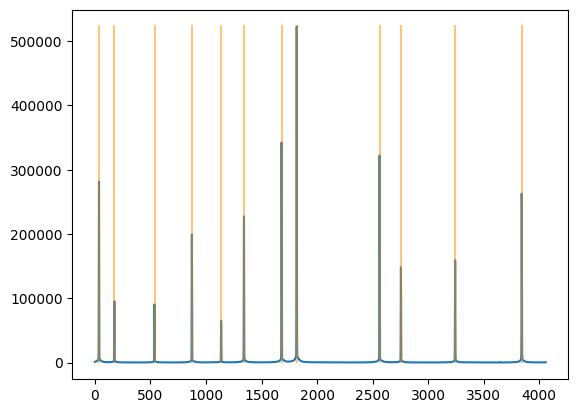

In [4]:
#Run wavelength calibration on comparison lamp file.

w=wcal(flamp)

C:\Users\ZY\Downloads\ecfzst_0056_CG4_8.fits
['#w', 'f']
It is written: CG4_8_unnorm.dat


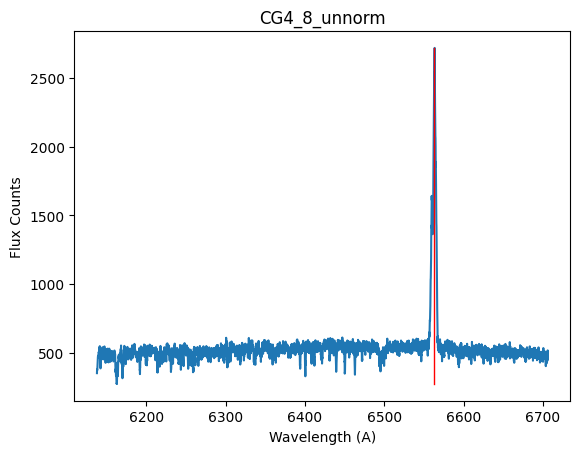

In [11]:
#Assign calibrated wavelengths to star flux. Check how it looks:
plotspec(w,fstar)
print(starfile)

#Save to a file for this star.
starname='CG4_8'
writedat('',starname+'_unnorm',[w,fstar],['#w','f'])